# 4.Preprocessing

In [83]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [84]:
df = pd.read_csv("C:/Users/DELL/Documents/VEMV/pycaret/work/Projets_professionnels/MedicalExpensesEstimation/data/raw/Medical cost.csv")
data = df.copy()
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520


In [85]:
# Division en ensemble d'entrainement et de test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

# car les smoker influencent beaucoup les charges
trainset, testset = train_test_split(data, train_size=0.8, shuffle=True, stratify= data['smoker'], random_state=0) 

In [86]:
# recréation des sous-ensembles de datsets
femmes = testset[testset['sex'] == 'female']
hommes = testset[testset['sex'] == 'male']

fumeurs = testset[testset['smoker'] == 'yes']
non_fumeurs = testset[testset['smoker'] == 'no']

In [87]:
data.shape

(1338, 7)

In [88]:
# gestion des NaN
def gestion_nan(df):
    df = df.dropna()
    #print(df.shape)
    return df

In [89]:
doublons = data.duplicated()
doublons.value_counts()

False    1337
True        1
Name: count, dtype: int64

In [90]:
# gestion des doublons
def gestion_doublons(df):
    df = df.drop_duplicates()
    return df

In [91]:
def normalisation(df):
   scaler = MinMaxScaler()
   cols_to_scale = df.select_dtypes(include=['number']).drop(['charges'], axis=1).columns 
   df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
   return df 

In [92]:
def preprocessing(df):
    df = gestion_nan(df)
    df = gestion_doublons(df)
    x = df.drop(['charges', 'region'], axis=1)
    y = df['charges']
    return x, y

In [93]:
x_train, y_train = preprocessing(trainset)

In [94]:
x_train.dtypes

age         float64
sex          object
bmi         float64
children    float64
smoker       object
dtype: object

In [95]:
x_test, y_test = preprocessing(testset)

## 

# 5. Modélisation

In [96]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_log_error, r2_score, root_mean_squared_error
from sklearn.model_selection import learning_curve, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [97]:
x_train.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker'], dtype='object')

In [104]:
numerical_features = x_train.drop(['sex', 'smoker'], axis=1).columns
categorical_features = ['sex', 'smoker']

preprocessor = ColumnTransformer(transformers=[
    ('smoker',OneHotEncoder(), ['smoker']),
    ('sex', OrdinalEncoder(), ['sex']),
    ('num', 'passthrough', numerical_features)
])

In [111]:
PR = make_pipeline(preprocessor, PolynomialFeatures(degree=2, include_bias=False),
                    SelectKBest(f_regression, k=19), LinearRegression())

DT = DecisionTreeRegressor()
RG = make_pipeline(preprocessor, PolynomialFeatures(degree=2, include_bias=False), Ridge())
RF = RandomForestRegressor(n_estimators=50)
SVM = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), SVR(kernel='linear', epsilon=0.1, C=1000 )) #, gamma=0.001))


In [106]:
x_train.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker'], dtype='object')

In [115]:
def evaluation(model):
    y_train_log = np.log(y_train)
    model.fit(x_train, y_train_log)
    y_pred_log = model.predict(x_test)
    y_pred = np.exp(y_pred_log)

    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmsle = root_mean_squared_log_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'RMSE: {rmse}')
    print(f'MAE:  {mae}')
    print(f'RMSLE:  {rmsle}')
    print(f'R2:  {r2}')

    residus = (y_test - y_pred)
    residus = pd.DataFrame(residus)

    N, train_score, val_score = learning_curve(model, x_train, y_train_log, 
                                               cv=4, scoring='neg_root_mean_squared_error', train_sizes=np.linspace(0.1, 1, 10))
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(N, train_score.mean(axis=1), label= 'Training')
    plt.plot(N, val_score.mean(axis=1), label='Validation')
    plt.ylabel('RMSLE')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.histplot(residus, label='Résidus', kde=True)
    plt.legend()

    return model

In [116]:
PR

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('smoker', OneHotEncoder(),
                                                  ['smoker']),
                                                 ('sex', OrdinalEncoder(),
                                                  ['sex']),
                                                 ('num', 'passthrough',
                                                  Index(['age', 'bmi', 'children'], dtype='object'))])),
                ('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('selectkbest',
                 SelectKBest(k=19,
                             score_func=<function f_regression at 0x00000187FA1B8EE0>)),
                ('linearregression', LinearRegression())])

RMSE: 4238.013184851535
MAE:  2175.702719923439
RMSLE:  0.3193299327717058
R2:  0.8796786740795479


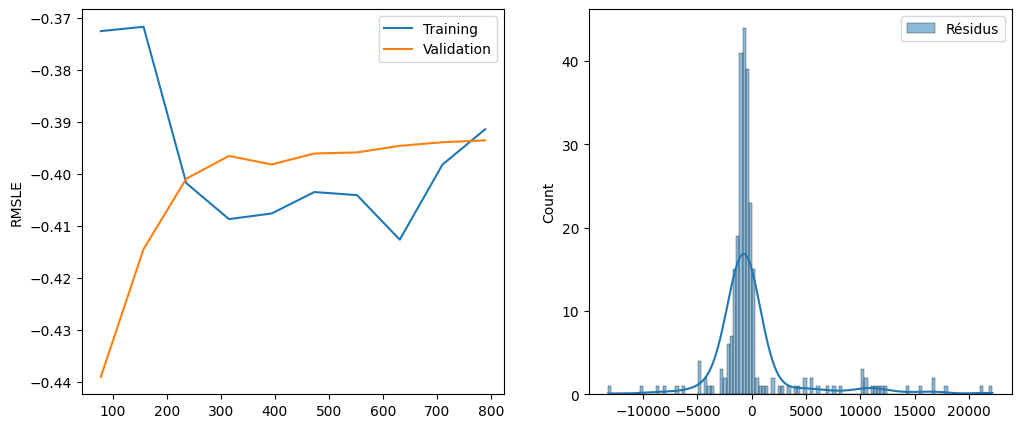

In [117]:
PR = evaluation(PR)

RMSE: 4081.682190983749
MAE:  2091.3326310068805
RMSLE:  0.3183535588543299
R2:  0.8883917302935854


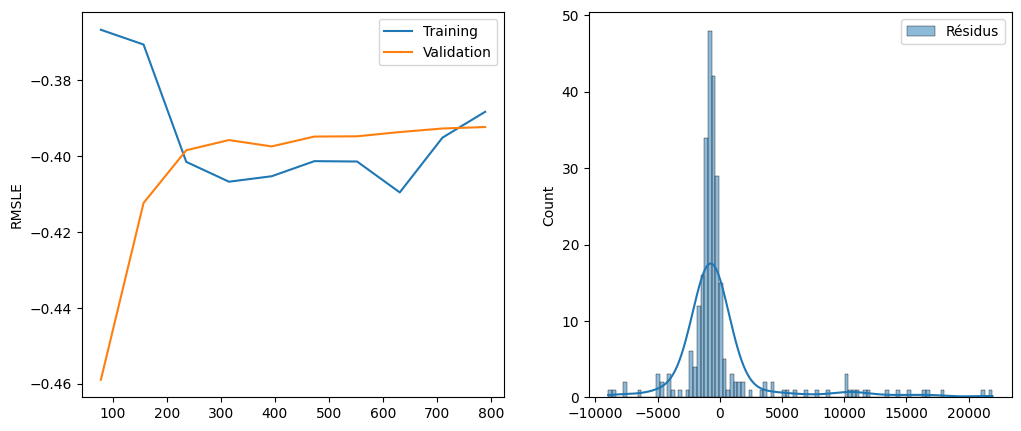

In [118]:
RG = evaluation(RG)

In [119]:
PR

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('smoker', OneHotEncoder(),
                                                  ['smoker']),
                                                 ('sex', OrdinalEncoder(),
                                                  ['sex']),
                                                 ('num', 'passthrough',
                                                  Index(['age', 'bmi', 'children'], dtype='object'))])),
                ('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('selectkbest',
                 SelectKBest(k=19,
                             score_func=<function f_regression at 0x00000187FA1B8EE0>)),
                ('linearregression', LinearRegression())])

In [121]:
# Étape 1 : Récupérer les noms des colonnes après ColumnTransformer
feature_names = PR.named_steps['columntransformer'].get_feature_names_out()

# Étape 2 : Générer les noms après PolynomialFeatures
poly_features = PR.named_steps['polynomialfeatures'].get_feature_names_out(feature_names)

# Étape 3 : Récupérer les indices sélectionnés par SelectKBest
selected_indices = PR.named_steps['selectkbest'].get_support(indices=True)

# Étape 4 : Sélectionner les noms finaux et les coefficients correspondants
selected_feature_names = poly_features[selected_indices]
coefficients = PR.named_steps['linearregression'].coef_

# Étape 5 : Construction du DataFrame final
coeff_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Coefficient': coefficients
})

C:\Users\DELL\AppData\Local\Temp\ipykernel_12696\374228397.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coeff_df.head(20), x='Coefficient', y='Feature', palette='coolwarm')


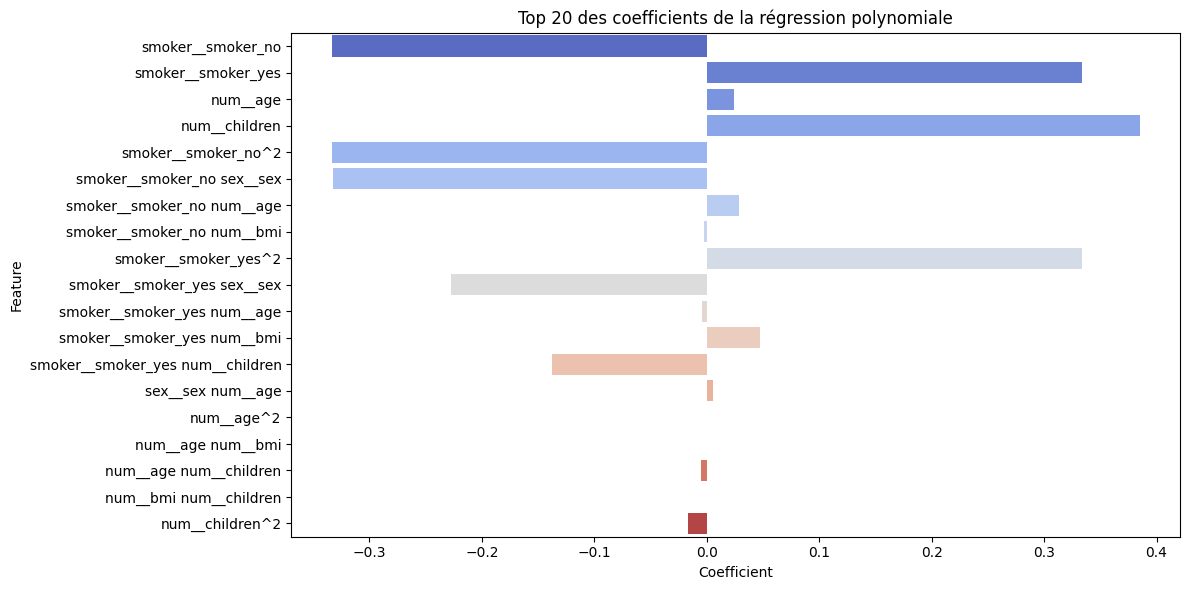

In [123]:
# Affichage des coefficients les plus élevés
plt.figure(figsize=(12, 6))
sns.barplot(data=coeff_df.head(20), x='Coefficient', y='Feature', palette='coolwarm')
plt.title('Top 20 des coefficients de la régression polynomiale')
plt.tight_layout()

### Vérification de la réponse aux exigences de base

### HOMMES VS FEMMES

In [124]:
# calcul des performances des métriques par sous-groupes
hommes = testset[testset['sex'] == 'male']
femmes = testset[testset['sex'] == 'female']

In [125]:
print(hommes.shape)
print(femmes.shape)

(140, 7)
(128, 7)


In [126]:
hommes = hommes.sample(femmes.shape[0])
hommes_x_test, hommes_y_test = preprocessing(hommes)

In [127]:
print(hommes.shape)
print(femmes.shape)

(128, 7)
(128, 7)


In [128]:
femmes_x_test, femmes_y_test = preprocessing(femmes)

In [129]:
# calcul des métriques par sexe
log_pred_h = PR.predict(hommes_x_test)

pred_h = np.exp(log_pred_h)

rmse = root_mean_squared_error(hommes_y_test, pred_h)
mae = mean_absolute_error(hommes_y_test, pred_h)
rmsle = root_mean_squared_log_error(hommes_y_test, pred_h)
r2 = r2_score(hommes_y_test, pred_h)

print(f'RMSE: {rmse}')
print(f'MAE:  {mae}')
print(f'RMSLE:  {rmsle}')
print(f'R2:  {r2}')


RMSE: 4190.257239486791
MAE:  2227.2460688370784
RMSLE:  0.34368300651063044
R2:  0.8880032792392748


In [130]:
# calcul des métriques par sexe
log_pred_f = PR.predict(femmes_x_test)

pred_f = np.exp(log_pred_f)

rmse = root_mean_squared_error(femmes_y_test, pred_f)
mae = mean_absolute_error(femmes_y_test, pred_f)
rmsle = root_mean_squared_log_error(femmes_y_test, pred_f)
r2 = r2_score(femmes_y_test, pred_f)

print(f'RMSE: {rmse}')
print(f'MAE:  {mae}')
print(f'RMSLE:  {rmsle}')
print(f'R2:  {r2}')


RMSE: 4415.68783892134
MAE:  2168.8086419769675
RMSLE:  0.30478957152916897
R2:  0.8627222727326145


In [131]:
residus_hommes = (hommes_y_test - pred_h)
residus_femmes = (femmes_y_test - pred_f)

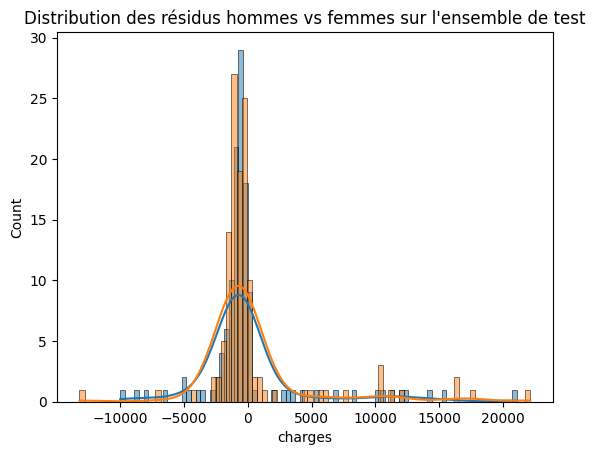

In [132]:
plt.figure()
sns.histplot(residus_hommes, kde=True)
sns.histplot(residus_femmes, kde=True)
plt.title("Distribution des résidus hommes vs femmes sur l'ensemble de test")
plt.show()

In [133]:
# comparaison des moyennes des prédictions
moy_h = pred_h.mean(axis=0)
moy_f = pred_f.mean(axis=0)
print(f"moyenne des prédictions chez les hommes: {moy_h:.2f}")
print(f"moyenne des prédictions chez les femmes: {moy_f:.2f}")

moyenne des prédictions chez les hommes: 12584.35
moyenne des prédictions chez les femmes: 12382.64


In [134]:
# pourcentage de similarité
taux = ((moy_f / moy_h) * 100)
print(f"taux de similarité: {taux:.0f} %") 

taux de similarité: 98 %


# Conclusion et prise de décision

Le modèle de **régrssion polynomiale** s'est avéré etre le meilleur modèle pour notre projet de modélisation des charges médicales dans le but d'estimer de manière fiable les charges médicales futures de ses clients afin d'ajuster ses primes d'assurance.
En effet, avec un **RMSLE de 0.32** notre modèle effectue les prédictions dans un intervalle fiable de **[charges réelles - charges réelles * 0.37; charges réelles - charges réelles * 0.37]**. Les bornes de cet intervalle étant des valeurs extremes et rares. De plus, comme nous pouvons le constater sur notre distribution des erreurs, il y'a une certaine normalité dans les résidus, preuve que les prédictions de notre modèle ne sont pas biaisées (sont objectives et suivent une logique claire). Par ailleurs, **un R2 de 89%** signifie que notre modèle explique **88% de la variance des charges médicales**.

Par ailleurs, le **schéma ci-dessus** présente l'influence de chaque variable sur les charges médicales.  